# Traindata 전처리

# JSON -> DataFrame

In [1]:
import os
import json
import pandas as pd

# 라벨링 JSON 파일이 있는 최상위 폴더 경로
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/라벨링데이터/"

# 실제 WAV 파일이 존재하는 원천 데이터의 최상위 경로
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/원천데이터/"

# 정상적으로 처리된 데이터 정보를 담을 리스트
data = []

# 오류 발생 시 해당 JSON 파일 또는 존재하지 않는 WAV 경로를 저장할 리스트
broken_files = []

# 라벨링 폴더 내부의 모든 JSON 파일을 재귀적으로 탐색
for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if file_name.endswith(".json"):
            # 현재 JSON 파일의 전체 경로 구성
            json_path = os.path.join(folder_path, file_name)
            try:
                # JSON 파일 열기 및 파싱
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                # JSON 내부 정보 추출
                emotion = content["화자정보"]["Emotion"]
                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")
                wav_file = content["파일정보"]["FileName"]

                # 현재 JSON 경로를 라벨 기준 상대경로로 변환
                relative_path = os.path.relpath(folder_path, start=label_root)

                # 상대 경로에서 모든 TL을 TS로 변경
                relative_path = relative_path.replace("TL", "TS")

                # WAV 경로를 원천 데이터 기준으로 재구성
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                # WAV 파일 존재 여부 확인
                if os.path.exists(wav_path):
                    # 정상 데이터 추가
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion,
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    # WAV 파일이 존재하지 않는 경우 로그에 기록
                    print(f"WAV 파일 없음: {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                # JSON 파싱 중 오류 발생 시 기록
                print(f"JSON 읽기 오류: {json_path}: {e}")
                broken_files.append(json_path)

# 정상적으로 수집된 데이터를 DataFrame으로 변환
df = pd.DataFrame(data)

# 결과 CSV 파일로 저장
os.makedirs("./data/usou", exist_ok=True)
df.to_csv("./data/usou/metadata_cleaned.csv", index=False)

# 오류가 발생한 경로들을 텍스트 파일로 저장
with open("./data/usou/broken_files.txt", "w") as f:
    for path in broken_files:
        f.write(path + "\n")

# 최종 처리 결과 출력
print(f"정상 처리된 JSON 수: {len(df)}")
print(f"에러 발생 수: {len(broken_files)}")


정상 처리된 JSON 수: 815491
에러 발생 수: 0


# MFCC 추출
-  MFCC 추출이란
    - 음성에서 특징을 뽑아낸 백터
-  데이터 형태
    - 2차원 배열(시간 프레임수, 13)
- 배치
    - 배치 : 전체 데이터를 나누어 처리하는 단위
- 나누는 이유
    - 메모리 부족으로 컴퓨터 프리징 발생





In [1]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

# ============================
# 1. 메타데이터 로드
# ============================
# 사전에 정제된 메타데이터 CSV 파일 경로
csv_path = "/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv"
df = pd.read_csv(csv_path)

# ============================
# 2. 설정값 정의
# ============================
sample_rate = 16000            # 음성 파일 샘플링 레이트 (Hz)
max_duration = 5.0             # WAV 파일 최대 로딩 시간 (초) → 너무 긴 파일 방지
save_interval = 10000          # 몇 개마다 배치로 저장할지 설정

# 저장용 리스트 초기화
mfcc_features = []             # MFCC 벡터 리스트
labels = []                    # 감정 레이블 리스트
error_files = []               # 처리 중 실패한 파일 목록
save_counter = 0               # 배치 저장 인덱스

# 저장 디렉토리 설정
save_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# ============================
# 3. MFCC 추출 루프
# ============================
for idx, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["wav_path"]  # 메타데이터에 포함된 wav 파일 전체 경로
    try:
        # WAV 파일 로딩 (최대 max_duration 초까지만 로드)
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)

        # MFCC 13차원 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # 시간 축 기준으로 전치 (time_step, n_mfcc)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])

    except Exception as e:
        # 에러 발생 시 파일 경로 저장
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    # 일정 수 이상 쌓이면 배치 저장 후 메모리 초기화
    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 남은 데이터가 있다면 마지막 배치 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ============================
# 4. 에러 파일 저장
# ============================
error_log_path = "/media/usou/PortableSSD/mldl_project/data/broken_audio_files.txt"
with open(error_log_path, "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ============================
# 5. 처리 결과 출력
# ============================
print(f"성공적으로 저장된 배치 수: {save_counter + 1}")
print(f"실패한 파일 수: {len(error_files)}")


/tmp/ipykernel_17508/736413005.py:12: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
100%|██████████| 815491/815491 [2:58:19<00:00, 76.22it/s]   


성공적으로 저장된 배치 수: 82
실패한 파일 수: 0


# 레이블 인코딩

In [20]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집
# ============================
# label_batch_*.npy 파일 경로 리스트
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 레이블 리스트 생성
all_labels = []
batch_label_data = []  # 배치별 데이터도 임시 저장
for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    batch_label_data.append(labels)
    all_labels.extend(labels)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 인코더 저장 (추후 예측 결과 복원용)
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 레이블 개수: {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"배치 수: {len(label_files)}")
print("레이블 인코딩 및 저장 완료")


총 레이블 개수: 815491
인코딩된 클래스 목록: ['Angry' 'Anxious' 'Embarrassed' 'Happy' 'Hurt' 'Neutrality' 'Sad' 'nan']
배치 수: 82
레이블 인코딩 및 저장 완료


# CNN 모델 정의

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    CNN 기반 음성 감정 분류 모델 정의

    Parameters:
        input_shape (tuple): 입력 데이터 형태 (예: (시간축 길이, MFCC 차원 수, 채널 수))
        num_classes (int): 분류할 감정 클래스 수

    Returns:
        tensorflow.keras.Model: 컴파일 완료된 CNN 모델
    """
    model = models.Sequential()

    # 첫 번째 컨볼루션 레이어: 필터 수 32, 커널 사이즈 3x3, 활성화 함수 ReLU
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    # 배치 정규화: 학습 안정성과 속도 개선
    model.add(layers.BatchNormalization())
    # 최대 풀링: 출력 크기 절반으로 줄임 (특징 추출과 과적합 방지)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 컨볼루션 레이어: 필터 수 64
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 세 번째 컨볼루션 레이어: 필터 수 128
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    # 전역 평균 풀링: 전체 피처 맵의 평균을 계산하여 1D 벡터로 변환
    model.add(layers.GlobalAveragePooling2D())

    # 완전 연결층(Dense Layer) 추가
    model.add(layers.Dense(128, activation='relu'))
    # 과적합 방지를 위한 드롭아웃 (30%)
    model.add(layers.Dropout(0.3))
    # 출력층: softmax로 감정 클래스 확률 예측
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일: Adam 옵티마이저, sparse_categorical_crossentropy 손실 함수, 정확도 지표
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


2025-03-27 14:35:02.667534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743053702.684248   21141 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743053702.688507   21141 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743053702.700707   21141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743053702.700724   21141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743053702.700725   21141 computation_placer.cc:177] computation placer alr

# Validation 전처리

# 메타데이터 csv로 저장

In [5]:
import os
import json
import pandas as pd

# ========================================
# 1. 경로 설정
# ========================================

# 라벨링 JSON 파일이 저장된 루트 폴더
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/라벨링데이터/VL1"

# 실제 음성 WAV 파일이 있는 루트 폴더
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1"

# ========================================
# 2. 결과 저장 리스트 초기화
# ========================================
data = []             # 메타데이터 저장용 리스트
broken_files = []     # 에러 발생한 파일 로그용 리스트

# ========================================
# 3. JSON 파일 순회 및 정보 추출
# ========================================
for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if file_name.endswith(".json"):
            json_path = os.path.join(folder_path, file_name)
            try:
                # JSON 파일 열기
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                # 화자 정보에서 감정, 스타일, 세부 감정 추출
                emotion = content["화자정보"]["Emotion"]
                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")

                # WAV 파일 이름 추출
                wav_file = content["파일정보"]["FileName"]

                # 현재 JSON 경로에서 라벨 루트를 기준으로 상대 경로 추출
                relative_path = os.path.relpath(folder_path, start=label_root)

                # 실제 WAV 파일 경로 생성
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                # WAV 파일이 존재하면 메타데이터에 추가
                if os.path.exists(wav_path):
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion,
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    # WAV 파일이 없는 경우 기록
                    print(f"WAV 파일 없음: {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                # JSON 파싱 실패 시 기록
                print(f"JSON 읽기 오류: {json_path}, 에러: {e}")
                broken_files.append(json_path)

# ========================================
# 4. 결과 저장
# ========================================

# DataFrame 생성
df = pd.DataFrame(data)

# 저장 경로 생성
os.makedirs("/media/usou/PortableSSD/mldl_project/data/validation", exist_ok=True)

# 메타데이터 CSV 저장
df.to_csv("/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv", index=False)

# 에러 파일 로그 저장
with open("/media/usou/PortableSSD/mldl_project/data/validation/broken_val_files.txt", "w") as f:
    for path in broken_files:
        f.write(path + "\n")

# 요약 출력
print(f"정상 처리된 JSON 수: {len(df)}")
print(f"에러 발생 수: {len(broken_files)}")


정상 처리된 JSON 수: 112157
에러 발생 수: 0


# MFCC 추출 Validation 용

In [6]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

# ========================================
# 1. 메타데이터 로드
# ========================================

# validation용 정제된 메타데이터 CSV 경로
csv_path = "/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv"
df = pd.read_csv(csv_path)

# ========================================
# 2. 설정값 정의
# ========================================

sample_rate = 16000             # 음성 샘플링 레이트 (16kHz)
max_duration = 5.0              # WAV 최대 로딩 시간 (초)
save_interval = 10000           # 배치 저장 기준 개수
save_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# 저장용 리스트 초기화
mfcc_features = []              # 추출된 MFCC 벡터 리스트
labels = []                     # 감정 레이블 리스트
error_files = []                # 실패한 파일 목록
save_counter = 0                # 배치 파일 번호

# ========================================
# 3. MFCC 추출 루프
# ========================================

for idx, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["wav_path"]

    try:
        # WAV 파일 로딩 (최대 max_duration 초까지만 로드)
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)

        # MFCC 추출 (13차원)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # 시간 축 기준으로 전치 (time_step, 13)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])

    except Exception as e:
        # 로딩 실패 시 에러 출력 및 로그 저장
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    # 일정 개수 이상이면 배치 저장
    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 루프 종료 후 남은 데이터 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ========================================
# 4. 에러 파일 저장
# ========================================

error_log_path = "/media/usou/PortableSSD/mldl_project/data/validation/broken_audio_files_val.txt"
with open(error_log_path, "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ========================================
# 5. 처리 결과 출력
# ========================================

print(f"성공적으로 저장된 배치 수: {save_counter + 1}")
print(f"실패한 파일 수: {len(error_files)}")


100%|██████████| 112157/112157 [27:27<00:00, 68.06it/s]

성공적으로 저장된 배치 수: 12
실패한 파일 수: 0


# Validation 데이터용 레이블 인코딩

In [7]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집
# ============================
# label_batch_*.npy 파일 경로 리스트
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 레이블 리스트 생성
all_labels = []
batch_label_data = []  # 배치별 데이터도 임시 저장
for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    batch_label_data.append(labels)
    all_labels.extend(labels)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 인코더 저장 (추후 예측 결과 복원용)
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 레이블 개수: {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"배치 수: {len(label_files)}")
print("레이블 인코딩 및 저장 완료")


총 레이블 개수: 815491
인코딩된 클래스 목록: ['Angry' 'Anxious' 'Embarrassed' 'Happy' 'Hurt' 'Neutrality' 'Sad' 'nan']
배치 수: 82
레이블 인코딩 및 저장 완료


# MFCC DataGenerator 클래스 생성

In [ ]:
import os
import numpy as np
import tensorflow as tf

class MFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_dir, prefix, batch_size=1, shuffle=True):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 배치 파일 목록 생성
        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])
        self.indices = list(range(len(self.mfcc_files)))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mfccs = []
        batch_labels = []

        for idx in batch_indices:
            mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
            label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

            mfcc_data = np.load(mfcc_path, allow_pickle=True)
            label_data = np.load(label_path)

            # 가장 긴 시퀀스 기준으로 padding
            max_len = max([x.shape[0] for x in mfcc_data])
            padded = tf.keras.preprocessing.sequence.pad_sequences(mfcc_data, maxlen=max_len, dtype='float32', padding='post')
            padded = np.expand_dims(padded, -1)  # (batch, time, n_mfcc, 1)

            batch_mfccs.append(padded)
            batch_labels.append(label_data)

        X = np.concatenate(batch_mfccs, axis=0)
        y = np.concatenate(batch_labels, axis=0)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# GPU 활성화 및 안정 설정 코드

In [3]:
import tensorflow as tf

# 1. GPU 장치 목록 출력
gpus = tf.config.list_physical_devices('GPU')
print("사용 가능한 GPU:", gpus)

# 2. 메모리 자동 증가 설정 (안정성을 위해 권장)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✔ GPU 메모리 자동 증가 설정 완료")
    except RuntimeError as e:
        print("⚠ 메모리 설정 중 오류 발생:", e)
else:
    print("❌ GPU를 찾을 수 없습니다. CPU로 진행됩니다.")


사용 가능한 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✔ GPU 메모리 자동 증가 설정 완료


# label_encoder.pkl을 로드해 동일하게 인코딩하는 코드

In [7]:
import os
import numpy as np
import glob
import pickle

# ============================
# 1. 설정
# ============================
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
encoded_label_dir = os.path.join(val_label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# 학습 데이터에서 저장한 LabelEncoder 로드
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# ============================
# 2. 모든 validation 레이블 수집
# ============================
label_files = sorted(glob.glob(os.path.join(val_label_dir, "label_batch_*.npy")))

for i, label_file in enumerate(label_files):
    labels = np.load(label_file, allow_pickle=True)
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"✅ Validation 레이블 인코딩 및 저장 완료 (배치 수: {len(label_files)})")


✅ Validation 레이블 인코딩 및 저장 완료 (배치 수: 12)


# CNN 모델 정의

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    CNN 기반 음성 감정 분류 모델 정의

    Parameters:
        input_shape (tuple): 입력 데이터 형태 (예: (시간축 길이, MFCC 차원 수, 채널 수))
        num_classes (int): 분류할 감정 클래스 수

    Returns:
        tensorflow.keras.Model: 컴파일 완료된 CNN 모델
    """
    model = models.Sequential()

    # [1] 첫 번째 컨볼루션 블록
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())               # 학습 안정성 향상
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))     # 공간 크기 감소

    # [2] 두 번째 컨볼루션 블록
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # [3] 세 번째 컨볼루션 블록
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())           # 피처맵 전체 평균값

    # [4] 완전 연결층 + 드롭아웃
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))                       # 과적합 방지

    # [5] 출력층 - 클래스 수만큼 softmax 출력
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 학습

In [8]:
import tensorflow as tf

# ============================
# 1. 데이터 제너레이터 생성
# ============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 안정 위해 소량으로 시작
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ============================
# 2. 클래스 수 설정
# ============================
import pickle

# 학습 데이터의 레이블 인코더를 불러와 클래스 수 확인
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 3. 입력 형태 설정
# ============================
# 예시 입력 크기 지정 (임의 값, 실제 학습 데이터 확인 후 조정 가능)
# 이 부분은 train_generator[0][0].shape 로 확인 가능
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# ============================
# 4. 모델 생성 및 요약
# ============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ============================
# 5. 콜백 정의 (모델 저장 및 EarlyStopping)
# ============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ============================
# 6. 학습 실행
# ============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743057731.960520   22337 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4550 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


ValueError: Computed output size would be negative. Received `inputs shape=(None, 37, 1, 64)`, `kernel shape=(3, 3, 64, 128)`, `dilation_rate=[1 1]`.

- 학습 실패한 이유 
- Conv2D 커널이 너무 커서 작은 입력에 비해 작동을 못함 - kernel size 축소 or padding ="same" 적용 -> 모델 재정의

# 안정적인 CNN 모델 정의

In [9]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    음성 감정 분류를 위한 CNN 모델 정의
    
    Parameters:
        input_shape (tuple): 입력 데이터의 형태 (시간축, MFCC 차원, 채널 수)
        num_classes (int): 분류할 감정 클래스 수
        
    Returns:
        keras.models.Sequential: 컴파일된 모델 객체
    """

    model = models.Sequential()

    # ===============================
    # [1] 첫 번째 컨볼루션 블록
    # ===============================
    # Conv2D: 32개의 필터, 3x3 커널, relu 활성화 함수 사용
    # padding='same'으로 출력 크기 감소 방지
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())  # 정규화로 학습 안정화
    model.add(layers.MaxPooling2D((2, 2)))  # 출력 크기 절반으로 축소

    # ===============================
    # [2] 두 번째 컨볼루션 블록
    # ===============================
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # ===============================
    # [3] 세 번째 컨볼루션 블록
    # ===============================
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # GlobalAveragePooling2D: 각 채널의 평균을 취해 1D 벡터로 변환
    model.add(layers.GlobalAveragePooling2D())

    # ===============================
    # [4] 완전 연결층 + 출력층
    # ===============================
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # 과적합 방지
    model.add(layers.Dense(num_classes, activation='softmax'))  # 감정 클래스 확률 출력

    # ===============================
    # [5] 모델 컴파일
    # ===============================
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# 학습
- 학습 도중 시스템이 멈추지 않도록 작은 배치 크기와 적절한 콜백 설정 포함

In [10]:
import os
import pickle
import tensorflow as tf

# ============================
# 1. 데이터 제너레이터 생성
# ============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 절약을 위한 작은 배치
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ============================
# 2. 레이블 인코더 로드 및 클래스 수 설정
# ============================
# 학습 데이터용 레이블 인코더를 통해 클래스 수 파악
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 3. 입력 형태 설정
# ============================
# 첫 배치에서 입력 형태 파악
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# ============================
# 4. 모델 생성
# ============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ============================
# 5. 콜백 설정
# ============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ============================
# 6. 학습 실행
# ============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 157, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 157, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 78, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 78, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 78, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 39, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1743058856.274355   22463 service.cc:152] XLA service 0x7e45fc006740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743058856.274372   22463 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-27 16:00:56.357242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1743058856.801990   22463 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743058856.922577   22463 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was c

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_22337/4153134984.py", line 65, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_3523]

- GPU 메모리 부족

# 모델 경량화 프루닝 라이브러리 및 모델 정의

In [4]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, models

def create_pruned_cnn_model(input_shape, num_classes):
    # 프루닝 설정: 가중치의 50%를 0으로 만듦 (비율은 조절 가능)
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.5,
            begin_step=0,
            end_step=1000  # 조절 가능
        )
    }

    model = models.Sequential()

    # 첫 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 두 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(64, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 세 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(128, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # 밀집층
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(128, activation='relu'),
        **pruning_params
    ))
    model.add(layers.Dropout(0.3))
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(num_classes, activation='softmax'),
        **pruning_params
    ))

    # 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


RecursionError: maximum recursion depth exceeded

In [6]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, models

def create_pruned_cnn_model(input_shape, num_classes):
    # 프루닝 설정: 가중치의 50%를 0으로 만듦 (비율은 조절 가능)
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.5,
            begin_step=0,
            end_step=1000  # 조절 가능
        )
    }

    model = models.Sequential()

    # 첫 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 두 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(64, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 세 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(128, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # 밀집층
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(128, activation='relu'),
        **pruning_params
    ))
    model.add(layers.Dropout(0.3))
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(num_classes, activation='softmax'),
        **pruning_params
    ))

    # 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


RecursionError: maximum recursion depth exceeded

- 프루닝 실패
1. Sequential 모델 안에 잘못된 레이어 구조를 넣었거나

2. 프루닝 대상에 이미 프루닝된 레이어를 다시 적용하려고 하거나

3. 모델 구조에서 무한 루프가 생겼거나

4. 너무 많은 프루닝 wrapper가 중첩된 경우



# 여기서 부터 

# MFCCDataGenerator 클래스
- tf.keras.utils.Sequence를 상속받아, 저장된 MFCC 및 레이블 배치 데이터를 Keras 모델 학습에 적합하게 동적으로 불러오고 전처리해주는 제너레이터

In [ ]:
import os
import numpy as np
import tensorflow as tf

class MFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_dir, prefix, batch_size=1, shuffle=True):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 배치 리스트 구성
        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])
        self.indices = list(range(len(self.mfcc_files)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        # 현재 배치 인덱스 범위 계산
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_mfccs = []
        batch_labels = []

        for idx in batch_indices:
            mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
            label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

            mfcc_data = np.load(mfcc_path, allow_pickle=True)
            label_data = np.load(label_path)

            # 시퀀스 길이 맞추기 (Zero-padding)
            max_len = max([x.shape[0] for x in mfcc_data])
            padded = tf.keras.preprocessing.sequence.pad_sequences(mfcc_data, maxlen=max_len, dtype='float32', padding='post')
            padded = np.expand_dims(padded, -1)  # CNN 입력 형식 맞추기

            batch_mfccs.append(padded)
            batch_labels.append(label_data)

        X = np.concatenate(batch_mfccs, axis=0)
        y = np.concatenate(batch_labels, axis=0)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


2025-03-28 10:05:11.283826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743123911.301970    4800 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743123911.306197    4800 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743123911.319183    4800 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743123911.319198    4800 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743123911.319199    4800 computation_placer.cc:177] computation placer alr

# 음성 감정 분류를 위한 CNN 모델을 정의한 함수

In [2]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    음성 감정 인식을 위한 CNN 모델 정의
    - 입력: MFCC 시퀀스 (batch, time, n_mfcc, 1)
    - 출력: 감정 클래스 확률 (softmax)
    """

    model = models.Sequential()

    # [1] 첫 번째 컨볼루션 블록
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # [2] 두 번째 컨볼루션 블록
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # [3] 세 번째 컨볼루션 블록
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())  # 피처맵 전체 평균값

    # [4] 완전 연결층
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))  # 감정 클래스 개수만큼 출력

    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# 학습

In [3]:
import os
import pickle
import tensorflow as tf

# ===============================
# [0] GPU 메모리 설정 (OOM 방지)
# ===============================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("❌ RuntimeError:", e)

# ===============================
# [1] 데이터 제너레이터 생성
# ===============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 안전 위해 최소 배치
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ===============================
# [2] 레이블 인코더 로드 및 클래스 수
# ===============================
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ===============================
# [3] 입력 형태 확인
# ===============================
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]

# ===============================
# [4] 모델 생성
# ===============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ===============================
# [5] 콜백 설정 (모델 저장 + 조기 종료)
# ===============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ===============================
# [6] 모델 학습
# ===============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


✅ GPU memory growth enabled


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743069273.900138   11267 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 157, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 157, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 78, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 78, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 39, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1743069277.256819   11330 service.cc:152] XLA service 0x7572800028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743069277.256835   11330 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-27 18:54:37.327430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1743069277.696580   11330 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743069277.792812   11330 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was c

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_11267/3582064655.py", line 75, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_3439]

# 모델 변경  PyTorch 기반 간단한 CNN 모델 예시

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


 # 데이터 로더 정의 (PyTorch용)

In [15]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os

class MFCCDataset(Dataset):
    def __init__(self, batch_dir, prefix):
        self.batch_dir = batch_dir
        self.prefix = prefix

        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
        label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

        # 여기서도 배치 데이터임
        mfcc_batch = np.load(mfcc_path, allow_pickle=True)
        label_batch = np.load(label_path)

        # 리스트로 묶어서 반환 (collate_fn에서 처리)
        return list(zip(mfcc_batch, label_batch))


# collate_fn 추가 (패딩과 텐서 변환)

In [16]:
def collate_fn(batch):
    batch = sum(batch, [])  # [(mfcc1, label1), ..., (mfccN, labelN)]로 평탄화
    seq_lens = [x[0].shape[0] for x in batch]
    max_len = max(seq_lens)
    n_mfcc = batch[0][0].shape[1]

    padded_mfccs = []
    labels = []

    for mfcc, label in batch:
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:mfcc.shape[0], :] = mfcc
        padded_mfccs.append(padded)
        labels.append(label)

    X = torch.tensor(padded_mfccs).unsqueeze(1)  # (batch, 1, time, n_mfcc)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# DataLoader 생성

In [17]:
train_dataset = MFCCDataset("/media/usou/PortableSSD/mldl_project/data/mfcc_batches", "mfcc")
val_dataset = MFCCDataset("/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches", "mfcc")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# 모델 학습

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# ============================
# 0. 기본 설정
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

num_classes = len(label_encoder.classes_)
model = AudioEmotionCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# ============================
# 1. 학습 루프
# ============================
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ============================
    # 2. 검증 루프
    # ============================
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_acc = val_correct / val_total
    print(f"🔵 Epoch {epoch+1}: Val Acc: {val_acc:.4f}")

    # ============================
    # 3. 모델 저장
    # ============================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved with Val Acc: {val_acc:.4f}")

print("✅ 학습 완료")


✅ Using device: cuda


Epoch 1/30 [Train]:   0%|          | 0/21 [00:01<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [5491, 1, 157, 13] at entry 0 and [10000, 1, 157, 13] at entry 1

- 에러 :  배치 안의 샘플들이 시퀀스 길이(time step)가 서로 달라서 torch.stack() 실패.
PyTorch DataLoader는 collate_fn이 내부에서 torch.stack()을 사용하기 때문에, 입력 데이터들 크기가 다르면 에러가 납니다.
TensorFlow에서는 padding으로 해결됐던 부분

- 해결 방안 : 배치 크기를 맞추는 collate_fn 함수 구현
    - collate_fn을 사용하여 배치 내 데이터 크기를 맞추는 방법을 추가

In [18]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pickle

# ============================
# 0. 기본 설정
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ============================
# 1. 레이블 인코더 로드 및 클래스 수 확인
# ============================
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 2. 데이터셋 클래스 정의
# ============================
class MFCCDataset(Dataset):
    def __init__(self, batch_dir, prefix):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.mfcc_files = sorted([f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")])

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
        label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

        mfcc_data = np.load(mfcc_path, allow_pickle=True)
        label_data = np.load(label_path)

        # 리스트 형태일 경우 numpy 배열로 변환
        if isinstance(mfcc_data, list):
            mfcc_data = np.array(mfcc_data)

        # 2D 배열인지 확인 (time, n_mfcc)
        if mfcc_data.ndim != 2:
            raise ValueError(f"[{mfcc_path}] shape 오류: (time, n_mfcc) 형식이 아님 → 실제 shape: {mfcc_data.shape}")

        return mfcc_data, label_data


# 패딩을 위한 collate_fn 정의
def collate_fn(batch):
    # 각 샘플은 (sequence_len, n_mfcc)
    seq_lens = [sample[0].shape[0] for sample in batch]
    max_len = max(seq_lens)

    padded_batch = []
    labels = []

    for mfcc_data, label_data in batch:
        # mfcc_data shape: (time, n_mfcc)
        time_len = mfcc_data.shape[0]
        n_mfcc = mfcc_data.shape[1]

        # (time, n_mfcc) → (max_len, n_mfcc)
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:time_len, :] = mfcc_data

        padded_batch.append(padded)
        labels.append(label_data)

    # (batch, 1, time, n_mfcc)
    X = torch.tensor(padded_batch).unsqueeze(1)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# 데이터셋 로딩
train_dataset = MFCCDataset(batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches", prefix="mfcc")
val_dataset = MFCCDataset(batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches", prefix="mfcc")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# ============================
# 3. 모델 정의
# ============================
class AudioEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 모델과 손실 함수, 옵티마이저 설정
model = AudioEmotionCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# ============================
# 4. 학습 루프
# ============================
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ============================
    # 5. 검증 루프
    # ============================
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_acc = val_correct / val_total
    print(f"🔵 Epoch {epoch+1}: Val Acc: {val_acc:.4f}")

    # ============================
    # 6. 모델 저장
    # ============================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved with Val Acc: {val_acc:.4f}")

print("✅ 학습 완료")


✅ Using device: cuda


Epoch 1/30 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/30 [Train]:   0%|          | 0/21 [00:01<?, ?it/s]


ValueError: [/media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_1.npy] shape 오류: (time, n_mfcc) 형식이 아님 → 실제 shape: (10000,)

- 에러
allow_pickle=True 옵션으로 불러온 데이터를 np.load() 하면, 원래는 List[np.ndarray] 혹은 (time, n_mfcc) 구조여야 합니다.

만약 이전에 이 mfcc_batch_1.npy를 배치 단위 리스트 형태로 저장했었다면:

지금처럼 __getitem__에서 개별 .npy를 꺼낼 경우 배치 전체가 한 개의 1D 배열로 저장되어 있을 수 있습니다.

- 해결 방법: 각 샘플을 개별 .npy 파일로 저장

In [53]:
import numpy as np
import os

# 원본 다중샘플 npy 경로
input_path = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_1.npy"

# 저장할 경로
output_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples"
os.makedirs(output_dir, exist_ok=True)

# 데이터 로드
data = np.load(input_path, allow_pickle=True)

# 각 샘플 저장
for i, sample in enumerate(data):
    save_path = os.path.join(output_dir, f"sample_{i:04d}.npy")
    np.save(save_path, sample)

print(f"✅ 총 {len(data)}개 샘플 저장 완료: {output_dir}")


✅ 총 10000개 샘플 저장 완료: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples


# 레이블 분할 저장 코드

In [54]:
import numpy as np
import os

# 레이블 경로
label_path = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels/label_batch_1.npy"
labels = np.load(label_path)

# 저장할 디렉토리
label_output_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels"
os.makedirs(label_output_dir, exist_ok=True)

# 분할 저장
for i, label in enumerate(labels):
    save_path = os.path.join(label_output_dir, f"label_{i:04d}.npy")
    np.save(save_path, label)

print(f"✅ 총 {len(labels)}개 레이블 저장 완료: {label_output_dir}")


✅ 총 10000개 레이블 저장 완료: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels


# MFCCSampleDataset 정의 (샘플 단위)

In [55]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch

class MFCCSampleDataset(Dataset):
    def __init__(self, sample_dir, label_dir):
        self.sample_paths = sorted([
            os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        mfcc = np.load(self.sample_paths[idx])          # shape: (time, n_mfcc)
        label = np.load(self.label_paths[idx])          # shape: ()

        # 텐서로 변환 (채널 추가)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # (1, time, n_mfcc)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mfcc_tensor, label_tensor


# collate_fn 정의

In [56]:
def collate_fn(batch):
    seq_lens = [x[0].shape[0] for x in batch]
    max_len = max(seq_lens)

    # n_mfcc 추정 시 더 안전하게
    n_mfcc = None
    for mfcc_data, _ in batch:
        if isinstance(mfcc_data, np.ndarray) and mfcc_data.ndim == 2:
            n_mfcc = mfcc_data.shape[1]
            break

    if n_mfcc is None:
        raise ValueError("모든 샘플에서 유효한 2D MFCC 데이터를 찾을 수 없습니다.")

    padded_batch = []
    labels = []

    for mfcc_data, label_data in batch:
        time_len = mfcc_data.shape[0]
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:time_len, :] = mfcc_data
        padded_batch.append(padded)
        labels.append(label_data)

    X = torch.tensor(padded_batch).unsqueeze(1)  # (batch, 1, time, n_mfcc)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# DataLoader 생성

In [57]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


#  기본 설정 및 모델 불러오기

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 모델 정의 (이전에 정의한 AudioEmotionCNN 사용)
model = AudioEmotionCNN(num_classes=8).to(device)  # 클래스 수에 맞게 수정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30


✅ Using device: cuda


# 학습 루프

In [59]:
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")


Epoch 1/30 [Train]:   0%|          | 0/2500 [00:00<?, ?it/s]


ValueError: 모든 샘플에서 유효한 2D MFCC 데이터를 찾을 수 없습니다.

# Tensorflow 로 변경

# 1. 샘플 단위 .npy 파일을 위한 DataGenerator 정의

In [60]:
import os
import numpy as np
import tensorflow as tf

class SampleMFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_dir, label_dir, batch_size=32, shuffle=True):
        self.mfcc_paths = sorted([
            os.path.join(mfcc_dir, f) for f in os.listdir(mfcc_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []

        for i in batch_indices:
            mfcc = np.load(self.mfcc_paths[i])  # (time, n_mfcc)
            label = np.load(self.label_paths[i])  # 정수 인코딩 레이블

            X.append(mfcc)
            y.append(label)

        # Zero-padding
        max_len = max(x.shape[0] for x in X)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(
            X, maxlen=max_len, padding='post', dtype='float32'
        )
        X_pad = np.expand_dims(X_pad, -1)  # (batch, time, n_mfcc, 1)
        y = np.array(y)

        return X_pad, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# CNN 모델 정의

In [61]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# 2.1  validation 데이터도 split 

In [65]:
import numpy as np
import os

val_input_path = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/mfcc_batch_0.npy"
val_label_path = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/label_batch_0.npy"

# 저장할 폴더
val_sample_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples"
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels"
os.makedirs(val_sample_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# 데이터 로드
mfcc_data = np.load(val_input_path, allow_pickle=True)
label_data = np.load(val_label_path)

# 저장
for i, (sample, label) in enumerate(zip(mfcc_data, label_data)):
    np.save(os.path.join(val_sample_dir, f"sample_{i:04d}.npy"), sample)
    np.save(os.path.join(val_label_dir, f"label_{i:04d}.npy"), label)

print(f"✅ validation용 {len(mfcc_data)}개 샘플 및 레이블 저장 완료")


✅ validation용 10000개 샘플 및 레이블 저장 완료


# 3. 콜백 설정 및 모델 학습

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ===============================
# [1] 학습 및 검증용 DataGenerator 정의
# ===============================
train_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels",
    batch_size=8
)

val_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels",
    batch_size=8
)

# ===============================
# [2] 입력 형태 확인 및 모델 생성
# ===============================
sample_input, _ = train_generator[0]
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# 클래스 수 확인
import glob
label_paths = sorted(glob.glob("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels/*.npy"))
all_labels = [int(np.load(p)) for p in label_paths]
num_classes = len(set(all_labels))

model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ===============================
# [3] 콜백 설정
# ===============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_tf.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# GPU 초기화를 위한 예열용 더미 실행 (CPU에서 실행)
with tf.device("/CPU:0"):
    model(tf.random.normal((1,) + input_shape))

# ===============================
# [4] 모델 학습 실행
# ===============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

print("✅ 모델 학습 완료 및 저장 완료")


총 클래스 수: 1


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 138, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 138, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 69, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 69, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 69, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 34, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
2025-03-28 11:16:45.087514: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 1).  Label values: 3 3 3 3 3 3 3 3
2025-03-28 11:16:45.087548: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 1).  Label values: 3 3 3 3 3 3 3 3
	 [[{{function_node __inference_one_step_on_data_6795}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_11170/2579500336.py", line 62, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/losses.py", line 2246, in sparse_categorical_crossentropy

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1964, in sparse_categorical_crossentropy

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 1).  Label values: 3 3 3 3 3 3 3 3
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_6922]

# gpu 사용 확인

In [69]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# cpu로 학습 시도

In [1]:
# 0. GPU 완전 비활성화 (가장 먼저 실행)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 1. 필수 라이브러리 임포트
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
import glob

# 2. 사용자 정의 DataGenerator
class SampleMFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_dir, label_dir, batch_size=32, shuffle=True):
        self.mfcc_paths = sorted([
            os.path.join(mfcc_dir, f) for f in os.listdir(mfcc_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mfcc = [np.load(self.mfcc_paths[i]) for i in batch_indexes]
        batch_label = [np.load(self.label_paths[i]).item() for i in batch_indexes]  # .item() 추가

        batch_mfcc = [np.expand_dims(x, axis=-1) for x in batch_mfcc]  # (time, n_mfcc, 1)

        max_len = max(x.shape[0] for x in batch_mfcc)
        padded_mfcc = np.array([
            np.pad(x, ((0, max_len - x.shape[0]), (0, 0), (0, 0)), mode='constant')
            for x in batch_mfcc
        ])

        labels = np.array(batch_label, dtype=np.int32)
        return padded_mfcc, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 3. CNN 모델 생성 함수
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. DataGenerator 설정
train_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels",
    batch_size=8
)

val_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels",
    batch_size=8
)

# 5. 입력 형상 및 클래스 수 확인
sample_input, _ = train_generator[0]
input_shape = sample_input.shape[1:]

label_paths = sorted(glob.glob("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels/*.npy"))
all_labels = [np.load(p).item() for p in label_paths]  # .item()으로 스칼라 추출
num_classes = len(set(all_labels))
print(f"클래스 수: {num_classes}")

# 6. 모델 생성 및 콜백 설정
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_tf.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 7. 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

print("모델 학습 완료 및 저장 완료")


2025-03-28 11:18:00.012173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743128280.028215   11313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743128280.033166   11313 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743128280.045344   11313 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743128280.045397   11313 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743128280.045399   11313 computation_placer.cc:177] computation placer alr

클래스 수: 1
Epoch 1/30


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-28 11:18:03.401681: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-28 11:18:03.401701: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-03-28 11:18:03.401706: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-03-28 11:18:03.401708: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_11313/2616878548.py", line 105, in <module>

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/losses/losses.py", line 2246, in sparse_categorical_crossentropy

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1964, in sparse_categorical_crossentropy

  File "/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 1).  Label values: 3 3 3 3 3 3 3 3
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_3421]

# 머신 러닝 시도
## 작업 순서
1. 데이터 로딩 및 통합
    - metadata_cleaned (train)
    - metadata_cleaned_val (validation)

2. 특징(X)과 레이블(y) 분리
    - MFCC는 X
    - 감정 레이블은 y

3. 레이블 인코딩
    - 문자열 레이블(Happy, Sad 등)을 숫자로 변환

4. 머신러닝 모델 선택 및 학습
    - 예: RandomForestClassifier, SVC, GradientBoosting, LogisticRegression

5. 검증 및 평가
    - accuracy_score, classification_report, confusion_matrix

# 데이터 로딩 및 통합

In [9]:
import numpy as np
import os
from glob import glob

# 경로
train_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/metadata_cleaned"
val_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/metadata_cleaned_val"

# 파일 불러오기
train_mfcc_paths = sorted(glob(os.path.join(train_dir, "*.npy")))
val_mfcc_paths = sorted(glob(os.path.join(val_dir, "*.npy")))

# 데이터 로딩
train_data = [np.load(f, allow_pickle=True).item() for f in train_mfcc_paths]
val_data = [np.load(f, allow_pickle=True).item() for f in val_mfcc_paths]

# 분리
X_train = [d["mfcc"] for d in train_data]
y_train = [d["emotion"] for d in train_data]

X_val = [d["mfcc"] for d in val_data]
y_val = [d["emotion"] for d in val_data]


# 특징(X)과 레이블(y) 분리

In [13]:
import pandas as pd

# 학습용 데이터 로딩
train_path = "/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv"
metadata_cleaned = pd.read_csv(train_path)

# 검증용 데이터 로딩
val_path = "/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv"
metadata_cleaned_val = pd.read_csv(val_path)

# X: MFCC 특징, y: 감정 레이블
X_train = metadata_cleaned["mfcc"]
y_train = metadata_cleaned["emotion"]

X_val = metadata_cleaned_val["mfcc"]
y_val = metadata_cleaned_val["emotion"]


/tmp/ipykernel_11956/3214042000.py:5: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_cleaned = pd.read_csv(train_path)


KeyError: 'mfcc'

In [14]:
print(metadata_cleaned.columns)


Index(['wav_path', 'emotion', 'style', 'sensitivity'], dtype='object')


In [17]:
base_mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples"

def load_mfcc_from_path(path_series):
    mfcc_list = []
    for rel_path in path_series:
        fname = os.path.splitext(os.path.basename(rel_path))[0]
        mfcc_path = os.path.join(base_mfcc_dir, f"{fname}.npy")
        if not os.path.exists(mfcc_path):
            print(f"⚠️ 누락된 MFCC 파일: {mfcc_path}")
            continue
        mfcc = np.load(mfcc_path)
        mfcc_list.append(mfcc.flatten())  # 머신러닝용 1D 벡터로
    return np.array(mfcc_list)


In [16]:
# X (특징) 로딩
X_train = load_mfcc_from_path(metadata_cleaned["wav_path"])
X_val = load_mfcc_from_path(metadata_cleaned_val["wav_path"])

# y (레이블) 추출
y_train = metadata_cleaned["emotion"].values
y_val = metadata_cleaned_val["emotion"].values


FileNotFoundError: [Errno 2] No such file or directory: '/media/usou/PortableSSD/mldl_project/data/mfcc_batches/0001_G1A3E1S0C0_PSB_000001.npy'

# MFCC 추출 이후 부터 딥러닝 다시 

## 데이터 로딩 및 전처리 

In [1]:
import numpy as np
import os
from glob import glob

# 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 파일 경로 정렬
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 로딩
X_raw = [np.load(p, allow_pickle=True) for p in mfcc_paths]
y_raw = [np.load(p) for p in label_paths]

# 리스트로 되어 있는 MFCC들을 한 리스트로 합치기
X_all = [sample for batch in X_raw for sample in batch]
y_all = np.concatenate(y_raw)

print(f"총 MFCC 샘플 수: {len(X_all)}")
print(f"총 레이블 수: {len(y_all)}")


총 MFCC 샘플 수: 815491
총 레이블 수: 815491


# MFCC 샘플 길이 정규화(패딩)

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# MFCC의 각 샘플은 (time, 13) 형태 → 시퀀스 길이 맞추기
max_len = max([x.shape[0] for x in X_all])
print("가장 긴 MFCC 시퀀스 길이:", max_len)

# (샘플 수, time, n_mfcc)
X_padded = pad_sequences(X_all, maxlen=max_len, padding='post', dtype='float32')
print("패딩된 X shape:", X_padded.shape)

# 마지막 차원을 명시적으로 추가: (샘플 수, time, n_mfcc, 1)
X_padded = np.expand_dims(X_padded, -1)


2025-03-28 15:40:02.434497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743144002.464161    6212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743144002.472918    6212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743144002.501484    6212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743144002.501502    6212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743144002.501503    6212 computation_placer.cc:177] computation placer alr

가장 긴 MFCC 시퀀스 길이: 157
패딩된 X shape: (815491, 157, 13)


In [3]:
# 검증용 MFCC 데이터 로딩
val_mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/encoded_labels"

val_mfcc_paths = sorted(glob(os.path.join(val_mfcc_dir, "mfcc_batch_*.npy")))
val_label_paths = sorted(glob(os.path.join(val_label_dir, "label_batch_*.npy")))

X_val_raw = [np.load(p, allow_pickle=True) for p in val_mfcc_paths]
y_val_raw = [np.load(p) for p in val_label_paths]

X_val_all = [sample for batch in X_val_raw for sample in batch]
y_val = np.concatenate(y_val_raw)

print(f"검증용 MFCC 샘플 수: {len(X_val_all)}")
print(f"검증용 레이블 수: {len(y_val)}")


검증용 MFCC 샘플 수: 112157
검증용 레이블 수: 112157


# CNN 기반 모델 정의

In [4]:
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
input_shape = X_padded.shape[1:]  # (157, 13, 1)
num_classes = len(np.unique(y_all))

model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743144025.889378    6212 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 157, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 157, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 78, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 78, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 39, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

# 콜백 설정 & 모델 학습 준비

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 저장 경로
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_cnn.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


# 학습

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=30,
    callbacks=callbacks
)


NameError: name 'X_train' is not defined

# 커널 재시작 후

In [1]:
# 1. MFCC 및 레이블 로딩
import numpy as np
import os
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 경로
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 데이터 로딩
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))
X_raw = [np.load(p, allow_pickle=True) for p in mfcc_paths]
y_raw = [np.load(p) for p in label_paths]

X_all = [sample for batch in X_raw for sample in batch]
y_all = np.concatenate(y_raw)

# 시퀀스 패딩
max_len = 157  # 고정
X_padded = pad_sequences(X_all, maxlen=max_len, padding='post', dtype='float32')
X_padded = np.expand_dims(X_padded, -1)

# 훈련/검증 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y_all, test_size=0.12, random_state=42, stratify=y_all
)

print("✅ 데이터 준비 완료")


2025-03-28 15:42:45.988723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743144166.048874    6433 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743144166.067261    6433 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743144166.186217    6433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743144166.186233    6433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743144166.186234    6433 computation_placer.cc:177] computation placer alr

: 

- 이 상황은 매우 자주 발생하는 Jupyter Notebook의 커널 메모리 한계 문제

- 위 방법으로 해결 예저
1. generator 정의
2. gc.collect()
3. model.fit(generator, validation_data=(X_val, y_val))



# 배치 제너레이터 정의(훈련용)

In [23]:
import numpy as np
import tensorflow as tf  # ✅ 반드시 필요


In [24]:
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.mfcc_paths = mfcc_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.max_len = max_len
        self.shuffle = shuffle
        self.indices = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []

        for i in batch_idx:
            mfcc = np.load(self.mfcc_paths[i], allow_pickle=True)
            label = np.load(self.label_paths[i])

            # 유효한 MFCC만 처리
            if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
                padded = tf.keras.preprocessing.sequence.pad_sequences(
                    [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
                )[0]
                X_batch.append(padded)
                y_batch.append(label)

        X_batch = np.expand_dims(np.array(X_batch), -1)  # (batch, time, n_mfcc, 1)
        y_batch = np.array(y_batch)

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# 제너레이터 생성 및 모델 학습

In [17]:
import gc
import tensorflow as tf

# 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

from glob import glob
import os

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 학습용 제너레이터
train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=64, max_len=157, shuffle=True)

# 가비지 컬렉션 실행 (메모리 확보)
gc.collect()

from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 모델 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)


# 콜백 정의
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 검증용 데이터는 메모리 적재 방식으로 유지
# 이 부분은 이전에 분리한 X_val, y_val을 사용해야 합니다
# 혹시 없다면 validation set 따로 만들 수 있도록 알려주세요

In [18]:
# 전체 레이블 로딩
all_labels = [np.load(p) for p in label_paths]
y_all = np.concatenate(all_labels)

# 전체 MFCC 로딩 (메모리 작은 검증셋만 로딩)
val_size = 112157  # 예: 전체의 약 13%
X_val_paths = mfcc_paths[-val_size:]
y_val_paths = label_paths[-val_size:]

# 검증 데이터 로딩
X_val_list = []
for path in X_val_paths:
    mfcc = np.load(path, allow_pickle=True)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        [mfcc], maxlen=157, padding='post', dtype='float32'
    )[0]
    X_val_list.append(padded)

X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.concatenate([np.load(p) for p in y_val_paths])


ValueError: setting an array element with a sequence.

In [19]:
X_val_list = []
valid_y_list = []

for mfcc_path, label_path in zip(X_val_paths, y_val_paths):
    mfcc = np.load(mfcc_path, allow_pickle=True)
    
    # (time, 13) 형식인지 확인
    if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [mfcc], maxlen=157, padding='post', dtype='float32'
        )[0]
        X_val_list.append(padded)

        label = np.load(label_path)
        valid_y_list.append(label)
    else:
        print("❌ 잘못된 MFCC:", mfcc_path)

# 최종 배열로 변환
X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.array(valid_y_list)

print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)


❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_0.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_1.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_10.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_11.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_12.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_13.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_14.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_15.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_16.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_17.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_18.npy
❌ 잘못된 MFCC: /media/usou/PortableSSD/mldl_project/data/mfcc_batches/

In [20]:
import numpy as np
import tensorflow as tf
from glob import glob
import os

# 경로
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 배치 파일 리스트
mfcc_batch_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_batch_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 검증용 비율 기준으로 뒤에서 N개 배치만 선택
val_batch_count = 10  # 예: 마지막 10개 배치만 사용
X_val_list = []
y_val_list = []

for mfcc_batch_path, label_batch_path in zip(mfcc_batch_paths[-val_batch_count:], label_batch_paths[-val_batch_count:]):
    mfcc_batch = np.load(mfcc_batch_path, allow_pickle=True)
    label_batch = np.load(label_batch_path)

    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=157, padding='post', dtype='float32'
            )[0]
            X_val_list.append(padded)
            y_val_list.append(label)

# 배열로 변환
X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.array(y_val_list)

print("✅ 검증용 X shape:", X_val.shape)
print("✅ 검증용 y shape:", y_val.shape)


✅ 검증용 X shape: (90982, 157, 13, 1)
✅ 검증용 y shape: (90982,)


In [25]:
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),  # 이 부분이 메모리에 있어야 해요!
    epochs=30,
    callbacks=callbacks
)


ValueError: setting an array element with a sequence.

# 다시 정리 커널 재시작 후

# 1 

In [1]:
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


2025-03-28 16:59:14.057234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743148754.070478    8542 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743148754.074722    8542 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743148754.087035    8542 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743148754.087050    8542 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743148754.087051    8542 computation_placer.cc:177] computation placer alr

# 2

In [2]:
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))


# 3

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 검증용 샘플 수 고정
val_sample_size = 112157

X_val_list = []
y_val_list = []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)

    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

# numpy 배열로 변환 (꼭 확인!)
X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)

print("✅ 검증 데이터 재구성 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)


✅ 검증 데이터 재구성 완료
검증용 X shape: (112157, 157, 13, 1)
검증용 y shape: (112157,)


# 4

In [ ]:
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.mfcc_paths = mfcc_paths
        self.label_paths = label_paths
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 전체 샘플을 flatten
        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)

            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []

        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
            )[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])

        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# 5

In [5]:
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 6

In [6]:
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


/home/usou/venv/superbad/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743148767.259957    8542 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


# 7

In [7]:
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)


NameError: name 'train_generator' is not defined

In [1]:
# 1. 기본 라이브러리
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


# 2. 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 3. 검증 데이터 구성
val_sample_size = 112157
X_val_list, y_val_list = [], []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)
    
    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)
print("✅ 검증 데이터 준비 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)

# 4. 학습용 제너레이터 정의 및 생성
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)
            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
            )[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])

        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=16)
print("✅ 유효한 학습용 샘플 수:", len(train_generator) * 16)

# 5. 모델 정의
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 6. 모델 생성 및 콜백 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 7. 가비지 컬렉션
gc.collect()

# 8. 학습 시작
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)


2025-03-28 17:33:08.166012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743150788.183049    7684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743150788.188898    7684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743150788.202084    7684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743150788.202097    7684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743150788.202098    7684 computation_placer.cc:177] computation placer alr

✅ 검증 데이터 준비 완료
검증용 X shape: (112157, 157, 13, 1)
검증용 y shape: (112157,)
✅ 유효한 학습용 샘플 수: 810992


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-28 17:33:24.716822: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743150804.717189    7684 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/30


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743150807.353714    7742 service.cc:152] XLA service 0x7cd894013f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743150807.353726    7742 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-28 17:33:27.412603: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743150807.737348    7742 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-28 17:33:28.101515: I external/local_

   42/50687 ━━━━━━━━━━━━━━━━━━━━ 3:12 4ms/step - accuracy: 0.2077 - loss: 2.0110   

I0000 00:00:1743150810.311860    7742 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30887/50687 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.5033 - loss: 1.3827

2025-03-28 17:35:03.203048: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.10 = (f32[6,64,78,6]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,32,78,6]{3,2,1,0} %bitcast.7026, f32[64,32,3,3]{3,2,1,0} %bitcast.6034, f32[64]{0} %bitcast.7086), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-28 17:35:03.257042: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted p

50671/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5427 - loss: 1.2738

2025-03-28 17:36:05.447048: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-03-28 17:36:05.984792: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-03-28 17:36:06.666576: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,157,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,157,13]{3,2,1,0} %bitcast.662, f32[32,1,3,3]{3,2,1,0} %bitcast.669, f32[32]{0} %bitcast.671), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id"


Epoch 1: val_accuracy improved from -inf to 0.61804, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - accuracy: 0.5427 - loss: 1.2737 - val_accuracy: 0.6180 - val_loss: 1.0669
Epoch 2/30
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7176 - loss: 0.7934
Epoch 2: val_accuracy improved from 0.61804 to 0.75991, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 166s 3ms/step - accuracy: 0.7177 - loss: 0.7934 - val_accuracy: 0.7599 - val_loss: 0.6334
Epoch 3/30
50670/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7515 - loss: 0.7006
Epoch 3: val_accuracy improved from 0.75991 to 0.76599, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.7515 - loss: 0.7006 - val_accuracy: 0.7660 - val_loss: 0.6305
Epoch 4/30
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7706 - loss: 0.6473
Epoch 4: val_accuracy improved from 0.76599 to 0.82801, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.7706 - loss: 0.6473 - val_accuracy: 0.8280 - val_loss: 0.4804
Epoch 5/30
50672/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.6156
Epoch 5: val_accuracy improved from 0.82801 to 0.85221, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - accuracy: 0.7824 - loss: 0.6156 - val_accuracy: 0.8522 - val_loss: 0.4106
Epoch 6/30
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7904 - loss: 0.5931
Epoch 6: val_accuracy did not improve from 0.85221
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.7904 - loss: 0.5931 - val_accuracy: 0.8495 - val_loss: 0.4139
Epoch 7/30
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7970 - loss: 0.5715
Epoch 7: val_accuracy did not improve from 0.85221
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.7970 - loss: 0.5715 - val_accuracy: 0.8343 - val_loss: 0.4614
Epoch 8/30
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030 - loss: 0.5562
Epoch 8: val_accuracy improved from 0.85221 to 0.86516, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - accuracy: 0.8030 - loss: 0.5562 - val_accuracy: 0.8652 - val_loss: 0.3749
Epoch 9/30
50672/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8081 - loss: 0.5446
Epoch 9: val_accuracy improved from 0.86516 to 0.86551, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8081 - loss: 0.5446 - val_accuracy: 0.8655 - val_loss: 0.3770
Epoch 10/30
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8110 - loss: 0.5344
Epoch 10: val_accuracy did not improve from 0.86551
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.8110 - loss: 0.5344 - val_accuracy: 0.8625 - val_loss: 0.3822
Epoch 11/30
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8143 - loss: 0.5248
Epoch 11: val_accuracy did not improve from 0.86551
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 125s 2ms/step - accuracy: 0.8143 - loss: 0.5248 - val_accuracy: 0.8642 - val_loss: 0.3781
Epoch 12/30
50686/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8167 - loss: 0.5182
Epoch 12: val_accuracy did not improve from 0.86551
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8167 - loss: 0.5182 - val_accuracy: 0.8644 - val_loss: 0.3801
Epoch 13/30
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - l

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8196 - loss: 0.5109 - val_accuracy: 0.8747 - val_loss: 0.3503
Epoch 14/30
50686/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8229 - loss: 0.5025
Epoch 14: val_accuracy improved from 0.87468 to 0.89463, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8229 - loss: 0.5025 - val_accuracy: 0.8946 - val_loss: 0.2945
Epoch 15/30
50672/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8236 - loss: 0.4989
Epoch 15: val_accuracy did not improve from 0.89463
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 123s 2ms/step - accuracy: 0.8236 - loss: 0.4989 - val_accuracy: 0.8833 - val_loss: 0.3277
Epoch 16/30
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8256 - loss: 0.4929
Epoch 16: val_accuracy did not improve from 0.89463
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8256 - loss: 0.4929 - val_accuracy: 0.8873 - val_loss: 0.3183
Epoch 17/30
50682/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8270 - loss: 0.4892
Epoch 17: val_accuracy did not improve from 0.89463
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8270 - loss: 0.4892 - val_accuracy: 0.8778 - val_loss: 0.3385
Epoch 18/30
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8297 - l

# 저장된 모델 불러오기


In [2]:
from tensorflow.keras.models import load_model

model_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
model = load_model(model_path)
print("✅ 모델 로드 완료")


✅ 모델 로드 완료


In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

2025-03-28 18:22:19.439648: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-03-28 18:22:20.130757: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_val, y_pred_classes)
print(f"✅ 검증 정확도: {acc:.4f}\n")

print("📊 분류 리포트:")
print(classification_report(y_val, y_pred_classes))

print("🌀 혼동 행렬:")
print(confusion_matrix(y_val, y_pred_classes))


✅ 검증 정확도: 0.8946

📊 분류 리포트:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     35952
           1       0.86      0.88      0.87     11985
           2       0.96      0.87      0.91     11974
           3       0.94      0.83      0.88     11664
           4       0.87      0.90      0.88     11943
           5       0.00      0.00      0.00         0
           6       0.92      0.89      0.91     27464
           7       0.28      1.00      0.44      1175

    accuracy                           0.89    112157
   macro avg       0.72      0.79      0.73    112157
weighted avg       0.91      0.89      0.90    112157

🌀 혼동 행렬:
[[33172   519   230    94   444    59   547   887]
 [  826 10521     4     6    24     4   356   244]
 [   87    37 10466    86   389   128   217   564]
 [   68    30    93  9707   609    40   543   574]
 [  141    92    73   302 10747    30   388   170]
 [    0     0     0     0     0     0     0     0]
 [  94

/home/usou/venv/test_super/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/usou/venv/test_super/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/usou/venv/test_super/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


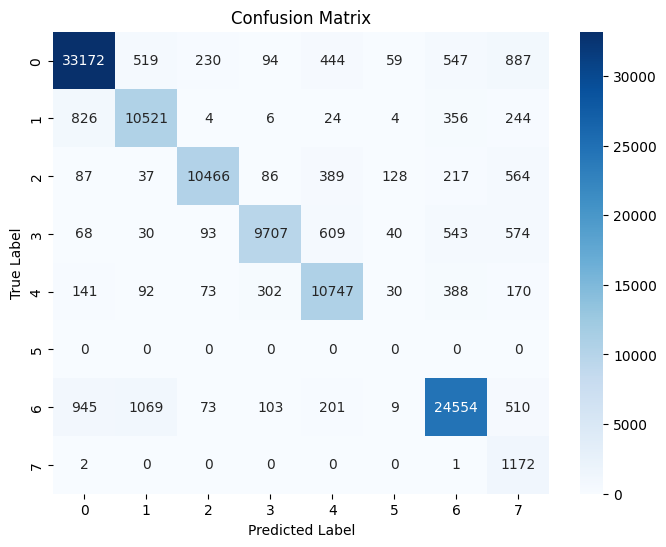

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 학습 로그 저장

In [9]:
import pickle

# 학습 직후 저장
with open("/media/usou/PortableSSD/mldl_project/models/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ 학습 로그 저장 완료")


✅ 학습 로그 저장 완료


# 학습 로그 불러 오기

In [10]:
import pickle

with open("/media/usou/PortableSSD/mldl_project/models/history.pkl", "rb") as f:
    history_dict = pickle.load(f)

print("✅ 학습 로그 불러오기 완료")


✅ 학습 로그 불러오기 완료


# 시각화

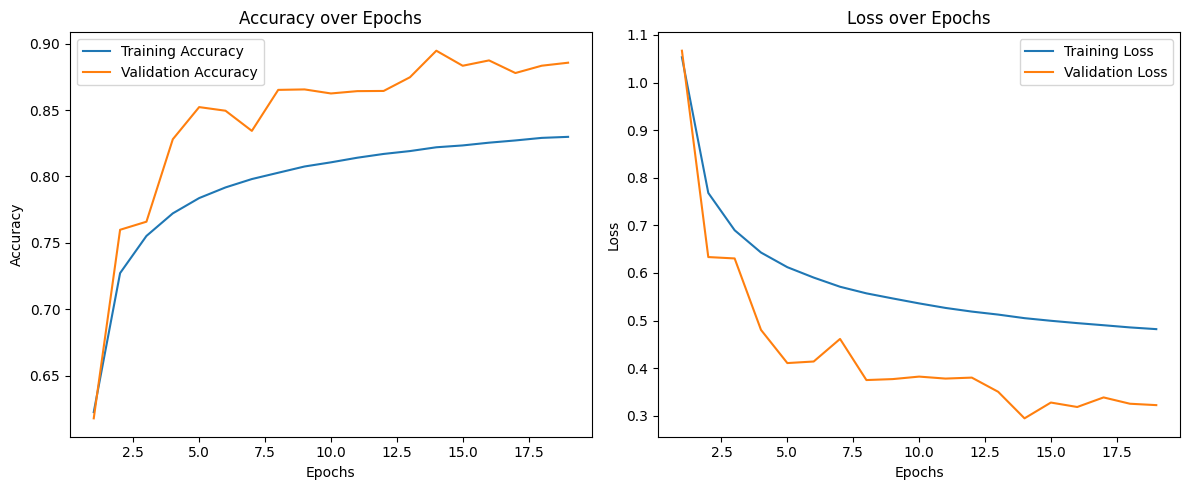

In [11]:
import matplotlib.pyplot as plt

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# epoch 300 으로 accuracy 더 올리기

In [1]:
# 1. 기본 라이브러리 불러오기 및 GPU 설정
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# GPU 메모리 과도할당 방지 설정
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 2. MFCC 및 레이블 파일 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 3. 검증 데이터셋 구성 (112157개 샘플)
val_sample_size = 112157
X_val_list, y_val_list = [], []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)
    
    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)

print("검증 데이터 준비 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)

# 4. 학습용 데이터 제너레이터 정의
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)
            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = pad_sequences([mfcc], maxlen=self.max_len, padding='post', dtype='float32')[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])
        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=16)
print("유효한 학습용 샘플 수:", len(train_generator) * 16)

# 5. CNN 모델 정의 함수
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 6. 모델 구성 및 콜백 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
]

# 7. 불필요한 메모리 수거
gc.collect()

# 8. 모델 학습 (epoch 300으로 확장)
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=300,
    callbacks=callbacks
)


2025-03-28 18:54:16.775607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743155656.793093   11297 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743155656.798809   11297 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743155656.812180   11297 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743155656.812194   11297 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743155656.812195   11297 computation_placer.cc:177] computation placer alr

검증 데이터 준비 완료
검증용 X shape: (112157, 157, 13, 1)
검증용 y shape: (112157,)
유효한 학습용 샘플 수: 810992


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-28 18:54:35.960404: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743155675.960509   11297 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/300


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743155678.641846   11365 service.cc:152] XLA service 0x78633c013290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743155678.641867   11365 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-28 18:54:38.691288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743155678.983289   11365 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-28 18:54:39.335420: I external/local_

   45/50687 ━━━━━━━━━━━━━━━━━━━━ 2:57 4ms/step - accuracy: 0.2402 - loss: 2.0074

I0000 00:00:1743155681.518078   11365 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42842/50687 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.5324 - loss: 1.3064

2025-03-28 18:56:54.441807: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.10 = (f32[6,64,78,6]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,32,78,6]{3,2,1,0} %bitcast.7026, f32[64,32,3,3]{3,2,1,0} %bitcast.6034, f32[64]{0} %bitcast.7086), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-28 18:56:54.495516: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted p

50681/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5459 - loss: 1.2688

2025-03-28 18:57:20.828417: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-03-28 18:57:21.380281: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-03-28 18:57:22.099486: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,157,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,157,13]{3,2,1,0} %bitcast.662, f32[32,1,3,3]{3,2,1,0} %bitcast.669, f32[32]{0} %bitcast.671), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id"


Epoch 1: val_accuracy improved from -inf to 0.73920, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 173s 3ms/step - accuracy: 0.5459 - loss: 1.2688 - val_accuracy: 0.7392 - val_loss: 0.7049
Epoch 2/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7200 - loss: 0.7889
Epoch 2: val_accuracy improved from 0.73920 to 0.76100, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 159s 3ms/step - accuracy: 0.7200 - loss: 0.7889 - val_accuracy: 0.7610 - val_loss: 0.6599
Epoch 3/300
50679/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7527 - loss: 0.6951
Epoch 3: val_accuracy improved from 0.76100 to 0.79591, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 163s 3ms/step - accuracy: 0.7527 - loss: 0.6951 - val_accuracy: 0.7959 - val_loss: 0.5647
Epoch 4/300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7702 - loss: 0.6490
Epoch 4: val_accuracy improved from 0.79591 to 0.83314, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 160s 3ms/step - accuracy: 0.7702 - loss: 0.6490 - val_accuracy: 0.8331 - val_loss: 0.4647
Epoch 5/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.6143
Epoch 5: val_accuracy did not improve from 0.83314
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 159s 3ms/step - accuracy: 0.7822 - loss: 0.6143 - val_accuracy: 0.7883 - val_loss: 0.5739
Epoch 6/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7913 - loss: 0.5904
Epoch 6: val_accuracy improved from 0.83314 to 0.83458, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - accuracy: 0.7913 - loss: 0.5904 - val_accuracy: 0.8346 - val_loss: 0.4563
Epoch 7/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7978 - loss: 0.5735
Epoch 7: val_accuracy improved from 0.83458 to 0.83699, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 160s 3ms/step - accuracy: 0.7978 - loss: 0.5735 - val_accuracy: 0.8370 - val_loss: 0.4477
Epoch 8/300
50685/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8021 - loss: 0.5592
Epoch 8: val_accuracy did not improve from 0.83699
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - accuracy: 0.8021 - loss: 0.5592 - val_accuracy: 0.8359 - val_loss: 0.4452
Epoch 9/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8073 - loss: 0.5455
Epoch 9: val_accuracy improved from 0.83699 to 0.85486, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 159s 3ms/step - accuracy: 0.8073 - loss: 0.5455 - val_accuracy: 0.8549 - val_loss: 0.4024
Epoch 10/300
50682/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.5345
Epoch 10: val_accuracy did not improve from 0.85486
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 163s 3ms/step - accuracy: 0.8108 - loss: 0.5345 - val_accuracy: 0.8383 - val_loss: 0.4449
Epoch 11/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8160 - loss: 0.5229
Epoch 11: val_accuracy improved from 0.85486 to 0.86806, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 170s 3ms/step - accuracy: 0.8160 - loss: 0.5229 - val_accuracy: 0.8681 - val_loss: 0.3678
Epoch 12/300
50671/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8172 - loss: 0.5182
Epoch 12: val_accuracy improved from 0.86806 to 0.88458, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8172 - loss: 0.5182 - val_accuracy: 0.8846 - val_loss: 0.3262
Epoch 13/300
50686/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8195 - loss: 0.5113
Epoch 13: val_accuracy did not improve from 0.88458
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8195 - loss: 0.5113 - val_accuracy: 0.8694 - val_loss: 0.3685
Epoch 14/300
50674/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8221 - loss: 0.5034
Epoch 14: val_accuracy did not improve from 0.88458
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8221 - loss: 0.5034 - val_accuracy: 0.8491 - val_loss: 0.4127
Epoch 15/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.4962
Epoch 15: val_accuracy did not improve from 0.88458
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8254 - loss: 0.4962 - val_accuracy: 0.8758 - val_loss: 0.3446
Epoch 16/300
50682/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8258

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8258 - loss: 0.4937 - val_accuracy: 0.8918 - val_loss: 0.3078
Epoch 17/300
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8277 - loss: 0.4890
Epoch 17: val_accuracy did not improve from 0.89182
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8277 - loss: 0.4890 - val_accuracy: 0.8887 - val_loss: 0.3169
Epoch 18/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8298 - loss: 0.4827
Epoch 18: val_accuracy did not improve from 0.89182
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8298 - loss: 0.4827 - val_accuracy: 0.8739 - val_loss: 0.3563
Epoch 19/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - loss: 0.4803
Epoch 19: val_accuracy did not improve from 0.89182
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8305 - loss: 0.4803 - val_accuracy: 0.8817 - val_loss: 0.3288
Epoch 20/300
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8319

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8351 - loss: 0.4676 - val_accuracy: 0.8956 - val_loss: 0.2927
Epoch 24/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8370 - loss: 0.4637
Epoch 24: val_accuracy did not improve from 0.89559
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8370 - loss: 0.4637 - val_accuracy: 0.8792 - val_loss: 0.3382
Epoch 25/300
50686/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - loss: 0.4606
Epoch 25: val_accuracy did not improve from 0.89559
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8378 - loss: 0.4606 - val_accuracy: 0.8947 - val_loss: 0.2959
Epoch 26/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8390 - loss: 0.4567
Epoch 26: val_accuracy did not improve from 0.89559
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8390 - loss: 0.4567 - val_accuracy: 0.8838 - val_loss: 0.3238
Epoch 27/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8395

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8395 - loss: 0.4554 - val_accuracy: 0.8977 - val_loss: 0.2871
Epoch 28/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.4530
Epoch 28: val_accuracy did not improve from 0.89774
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8406 - loss: 0.4531 - val_accuracy: 0.8882 - val_loss: 0.3185
Epoch 29/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.4518
Epoch 29: val_accuracy improved from 0.89774 to 0.90023, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8411 - loss: 0.4518 - val_accuracy: 0.9002 - val_loss: 0.2826
Epoch 30/300
50669/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8414 - loss: 0.4496
Epoch 30: val_accuracy did not improve from 0.90023
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8414 - loss: 0.4496 - val_accuracy: 0.8902 - val_loss: 0.3096
Epoch 31/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.4449
Epoch 31: val_accuracy did not improve from 0.90023
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8433 - loss: 0.4449 - val_accuracy: 0.8808 - val_loss: 0.3314
Epoch 32/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.4447
Epoch 32: val_accuracy improved from 0.90023 to 0.90044, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8434 - loss: 0.4447 - val_accuracy: 0.9004 - val_loss: 0.2819
Epoch 33/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.4404
Epoch 33: val_accuracy improved from 0.90044 to 0.90689, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8449 - loss: 0.4404 - val_accuracy: 0.9069 - val_loss: 0.2638
Epoch 34/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.4406
Epoch 34: val_accuracy did not improve from 0.90689
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8442 - loss: 0.4406 - val_accuracy: 0.8980 - val_loss: 0.2845
Epoch 35/300
50670/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.4384
Epoch 35: val_accuracy did not improve from 0.90689
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8453 - loss: 0.4384 - val_accuracy: 0.9003 - val_loss: 0.2773
Epoch 36/300
50673/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.4344
Epoch 36: val_accuracy did not improve from 0.90689
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8472 - loss: 0.4344 - val_accuracy: 0.9014 - val_loss: 0.2747
Epoch 37/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8476 - loss: 0.4340 - val_accuracy: 0.9091 - val_loss: 0.2561
Epoch 39/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8476 - loss: 0.4324
Epoch 39: val_accuracy did not improve from 0.90906
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - accuracy: 0.8476 - loss: 0.4324 - val_accuracy: 0.8990 - val_loss: 0.2849
Epoch 40/300
50670/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8486 - loss: 0.4299
Epoch 40: val_accuracy did not improve from 0.90906
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 153s 3ms/step - accuracy: 0.8486 - loss: 0.4299 - val_accuracy: 0.9054 - val_loss: 0.2668
Epoch 41/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.4309
Epoch 41: val_accuracy improved from 0.90906 to 0.91300, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8484 - loss: 0.4309 - val_accuracy: 0.9130 - val_loss: 0.2459
Epoch 42/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.4303
Epoch 42: val_accuracy did not improve from 0.91300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8490 - loss: 0.4303 - val_accuracy: 0.8968 - val_loss: 0.2891
Epoch 43/300
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.4265
Epoch 43: val_accuracy did not improve from 0.91300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8501 - loss: 0.4265 - val_accuracy: 0.9112 - val_loss: 0.2540
Epoch 44/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.4259
Epoch 44: val_accuracy did not improve from 0.91300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8501 - loss: 0.4259 - val_accuracy: 0.9036 - val_loss: 0.2725
Epoch 45/300
50674/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8508 - loss: 0.4248 - val_accuracy: 0.9147 - val_loss: 0.2441
Epoch 46/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.4237
Epoch 46: val_accuracy did not improve from 0.91468
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8504 - loss: 0.4237 - val_accuracy: 0.9070 - val_loss: 0.2596
Epoch 47/300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8521 - loss: 0.4212
Epoch 47: val_accuracy did not improve from 0.91468
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8521 - loss: 0.4212 - val_accuracy: 0.9067 - val_loss: 0.2623
Epoch 48/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.4208
Epoch 48: val_accuracy did not improve from 0.91468
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8518 - loss: 0.4208 - val_accuracy: 0.9103 - val_loss: 0.2514
Epoch 49/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8517 - loss: 0.4210 - val_accuracy: 0.9147 - val_loss: 0.2484
Epoch 50/300
50672/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.4195
Epoch 50: val_accuracy did not improve from 0.91474
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8528 - loss: 0.4195 - val_accuracy: 0.8877 - val_loss: 0.3149
Epoch 51/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.4202
Epoch 51: val_accuracy did not improve from 0.91474
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 134s 3ms/step - accuracy: 0.8528 - loss: 0.4202 - val_accuracy: 0.9029 - val_loss: 0.2697
Epoch 52/300
50674/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.4160
Epoch 52: val_accuracy did not improve from 0.91474
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8539 - loss: 0.4160 - val_accuracy: 0.9108 - val_loss: 0.2498
Epoch 53/300
50685/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8558 - loss: 0.4094 - val_accuracy: 0.9168 - val_loss: 0.2366
Epoch 64/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.4060
Epoch 64: val_accuracy did not improve from 0.91675
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8574 - loss: 0.4060 - val_accuracy: 0.9080 - val_loss: 0.2606
Epoch 65/300
50682/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.4064
Epoch 65: val_accuracy did not improve from 0.91675
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8568 - loss: 0.4064 - val_accuracy: 0.9064 - val_loss: 0.2663
Epoch 66/300
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.4048
Epoch 66: val_accuracy improved from 0.91675 to 0.91869, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8576 - loss: 0.4048 - val_accuracy: 0.9187 - val_loss: 0.2315
Epoch 67/300
50669/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.4057
Epoch 67: val_accuracy did not improve from 0.91869
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8565 - loss: 0.4057 - val_accuracy: 0.9023 - val_loss: 0.2709
Epoch 68/300
50674/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4040
Epoch 68: val_accuracy did not improve from 0.91869
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8577 - loss: 0.4040 - val_accuracy: 0.9061 - val_loss: 0.2615
Epoch 69/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8580 - loss: 0.4032
Epoch 69: val_accuracy did not improve from 0.91869
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8580 - loss: 0.4032 - val_accuracy: 0.9029 - val_loss: 0.2662
Epoch 70/300
50667/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8596 - loss: 0.4002 - val_accuracy: 0.9236 - val_loss: 0.2172
Epoch 73/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.4017
Epoch 73: val_accuracy did not improve from 0.92358
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8586 - loss: 0.4017 - val_accuracy: 0.9091 - val_loss: 0.2503
Epoch 74/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.4010
Epoch 74: val_accuracy did not improve from 0.92358
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8592 - loss: 0.4010 - val_accuracy: 0.9159 - val_loss: 0.2389
Epoch 75/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.4002
Epoch 75: val_accuracy did not improve from 0.92358
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 157s 3ms/step - accuracy: 0.8596 - loss: 0.4002 - val_accuracy: 0.9196 - val_loss: 0.2303
Epoch 76/300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8611 - loss: 0.3948 - val_accuracy: 0.9247 - val_loss: 0.2130
Epoch 87/300
50669/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3950
Epoch 87: val_accuracy did not improve from 0.92469
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8612 - loss: 0.3950 - val_accuracy: 0.9220 - val_loss: 0.2231
Epoch 88/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.3946
Epoch 88: val_accuracy did not improve from 0.92469
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8619 - loss: 0.3946 - val_accuracy: 0.9144 - val_loss: 0.2426
Epoch 89/300
50673/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.3929
Epoch 89: val_accuracy did not improve from 0.92469
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8623 - loss: 0.3929 - val_accuracy: 0.9098 - val_loss: 0.2524
Epoch 90/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8628 - loss: 0.3891 - val_accuracy: 0.9266 - val_loss: 0.2087
Epoch 91/300
50667/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3922
Epoch 91: val_accuracy did not improve from 0.92656
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8616 - loss: 0.3922 - val_accuracy: 0.9164 - val_loss: 0.2351
Epoch 92/300
50672/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.3903
Epoch 92: val_accuracy did not improve from 0.92656
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8628 - loss: 0.3903 - val_accuracy: 0.9218 - val_loss: 0.2210
Epoch 93/300
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.3898
Epoch 93: val_accuracy did not improve from 0.92656
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8630 - loss: 0.3898 - val_accuracy: 0.9154 - val_loss: 0.2413
Epoch 94/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8627

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8658 - loss: 0.3834 - val_accuracy: 0.9279 - val_loss: 0.2043
Epoch 108/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8654 - loss: 0.3848
Epoch 108: val_accuracy did not improve from 0.92791
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8654 - loss: 0.3848 - val_accuracy: 0.9177 - val_loss: 0.2304
Epoch 109/300
50682/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.3844
Epoch 109: val_accuracy did not improve from 0.92791
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 129s 3ms/step - accuracy: 0.8650 - loss: 0.3844 - val_accuracy: 0.9188 - val_loss: 0.2258
Epoch 110/300
50678/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3821
Epoch 110: val_accuracy improved from 0.92791 to 0.93033, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8655 - loss: 0.3821 - val_accuracy: 0.9303 - val_loss: 0.2001
Epoch 111/300
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3853
Epoch 111: val_accuracy did not improve from 0.93033
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8641 - loss: 0.3853 - val_accuracy: 0.9193 - val_loss: 0.2261
Epoch 112/300
50667/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.3816
Epoch 112: val_accuracy did not improve from 0.93033
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8656 - loss: 0.3816 - val_accuracy: 0.9157 - val_loss: 0.2354
Epoch 113/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8649 - loss: 0.3833
Epoch 113: val_accuracy did not improve from 0.93033
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8649 - loss: 0.3833 - val_accuracy: 0.9158 - val_loss: 0.2356
Epoch 114/300
50676/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8678 - loss: 0.3755 - val_accuracy: 0.9328 - val_loss: 0.1928
Epoch 135/300
50684/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.3767
Epoch 135: val_accuracy did not improve from 0.93279
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8677 - loss: 0.3767 - val_accuracy: 0.9213 - val_loss: 0.2210
Epoch 136/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3734
Epoch 136: val_accuracy did not improve from 0.93279
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 151s 3ms/step - accuracy: 0.8692 - loss: 0.3734 - val_accuracy: 0.9274 - val_loss: 0.2058
Epoch 137/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.3750
Epoch 137: val_accuracy did not improve from 0.93279
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 156s 3ms/step - accuracy: 0.8683 - loss: 0.3750 - val_accuracy: 0.9286 - val_loss: 0.2024
Epoch 138/300
50675/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8695 - loss: 0.3717 - val_accuracy: 0.9337 - val_loss: 0.1905
Epoch 158/300
50686/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.3685
Epoch 158: val_accuracy improved from 0.93366 to 0.93542, saving model to /media/usou/PortableSSD/mldl_project/models/best_model_generator.h5


50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8704 - loss: 0.3685 - val_accuracy: 0.9354 - val_loss: 0.1852
Epoch 159/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3703
Epoch 159: val_accuracy did not improve from 0.93542
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.8697 - loss: 0.3703 - val_accuracy: 0.9157 - val_loss: 0.2349
Epoch 160/300
50683/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3677
Epoch 160: val_accuracy did not improve from 0.93542
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8706 - loss: 0.3677 - val_accuracy: 0.9167 - val_loss: 0.2330
Epoch 161/300
50680/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8714 - loss: 0.3670
Epoch 161: val_accuracy did not improve from 0.93542
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8714 - loss: 0.3670 - val_accuracy: 0.9178 - val_loss: 0.2280
Epoch 162/300
50685/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

50687/50687 ━━━━━━━━━━━━━━━━━━━━ 128s 3ms/step - accuracy: 0.8716 - loss: 0.3647 - val_accuracy: 0.9415 - val_loss: 0.1709
Epoch 189/300
50677/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3644
Epoch 189: val_accuracy did not improve from 0.94152
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 3ms/step - accuracy: 0.8718 - loss: 0.3644 - val_accuracy: 0.9182 - val_loss: 0.2298
Epoch 190/300
50669/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8714 - loss: 0.3637
Epoch 190: val_accuracy did not improve from 0.94152
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8714 - loss: 0.3637 - val_accuracy: 0.9234 - val_loss: 0.2151
Epoch 191/300
50668/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3637
Epoch 191: val_accuracy did not improve from 0.94152
50687/50687 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.8711 - loss: 0.3637 - val_accuracy: 0.9184 - val_loss: 0.2270
Epoch 192/300
50685/50687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

# 모델 저장 및 시각화

✅ 학습 로그 저장 완료


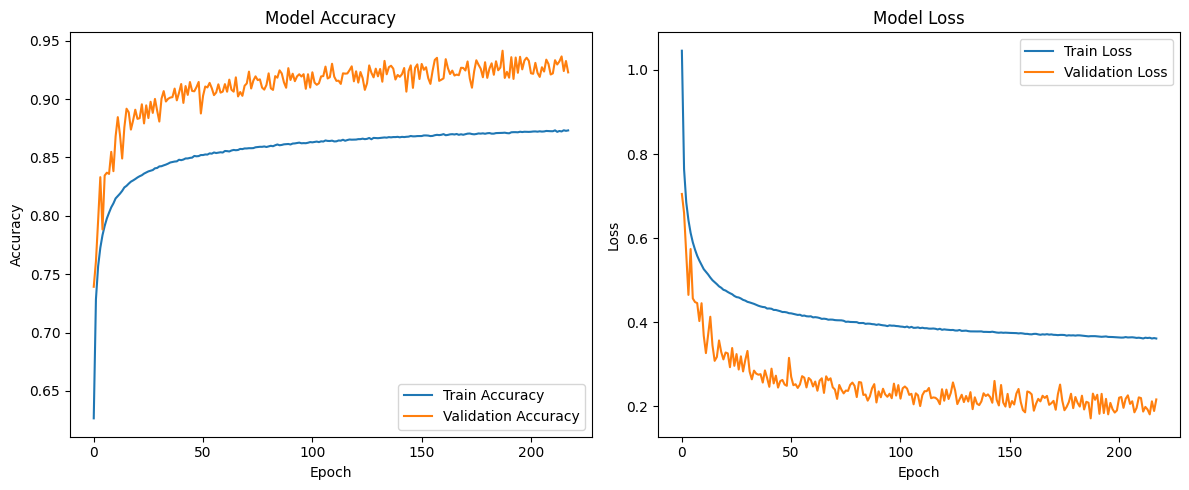

In [2]:
import json
import matplotlib.pyplot as plt

# 로그 저장 경로
log_path = "/media/usou/PortableSSD/mldl_project/models/train_history_log.json"

# history 객체를 JSON으로 저장
with open(log_path, "w") as f:
    json.dump(history.history, f)
print("✅ 학습 로그 저장 완료")

# 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# .keras 포맷 으로 저장

In [1]:
from tensorflow.keras.models import load_model

model = load_model("/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5")


2025-03-31 18:16:18.843871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743412578.894178    7225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743412578.909071    7225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743412579.033035    7225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743412579.033076    7225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743412579.033078    7225 computation_placer.cc:177] computation placer alr

In [2]:
model.save("best_model_generator_voice_emotion_analyze.keras")

# 모델에서 클래스 수 확인하는 코드

In [10]:
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model("best_model_generator_voice_emotion_analyze.keras")

# 출력층의 유닛 수로 클래스 수 확인
num_classes = model.output_shape[-1]
print(f"이 모델은 {num_classes}개의 감정을 분류합니다.")


이 모델은 8개의 감정을 분류합니다.


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
import pandas as pd

# 메타데이터 로딩
df_train = pd.read_csv("/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv")
df_val = pd.read_csv("/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv")

# 감정 열 병합 후 NaN 제거 및 문자열로 변환
all_emotions = pd.concat([df_train["emotion"], df_val["emotion"]]).dropna().astype(str)
emotion_classes = sorted(all_emotions.unique())

print("감정 클래스 목록:", emotion_classes)
print("감정 개수:", len(emotion_classes))


/tmp/ipykernel_7225/2016716980.py:4: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv")


감정 클래스 목록: ['Angry', 'Anxious', 'Embarrassed', 'Happy', 'Hurt', 'Neutrality', 'Sad']
감정 개수: 7


In [15]:
# 모든 감정 모아보기 (dropna 전 포함)
all_emotions_raw = pd.concat([df_train["emotion"], df_val["emotion"]]).astype(str)
all_labels = all_emotions_raw.unique()

# LabelEncoder 기준 클래스
le_classes = le.classes_

print("데이터셋 전체 감정 목록:", sorted(all_labels))
print("LabelEncoder 기준 감정 목록:", le_classes)


데이터셋 전체 감정 목록: ['Angry', 'Anxious', 'Embarrassed', 'Happy', 'Hurt', 'Neutrality', 'Sad', 'nan']
LabelEncoder 기준 감정 목록: ['Angry' 'Anxious' 'Embarrassed' 'Happy' 'Hurt' 'Neutrality' 'Sad']


# 테스트

##  m4a, mp4, mp3 → wav 변환
- pip install pydub
- sudo apt install ffmpeg

In [32]:
!pip install moviepy


In [33]:
import os
from pydub import AudioSegment
from moviepy.editor import VideoFileClip

def convert_to_wav(input_path, output_path=None):
    """
    오디오 또는 비디오 파일을 WAV로 변환합니다.
    지원 포맷: .wav, .m4a, .mp3, .mp4

    :param input_path: 입력 파일 경로
    :param output_path: 변환된 WAV 파일 경로 (없으면 같은 이름으로 .wav 저장)
    :return: 변환된 WAV 파일 경로
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"파일이 존재하지 않아요: {input_path}")

    ext = os.path.splitext(input_path)[1].lower()
    if output_path is None:
        output_path = os.path.splitext(input_path)[0] + ".wav"

    if ext == ".mp4":
        video = VideoFileClip(input_path)
        audio = video.audio
        audio.write_audiofile(output_path, verbose=False, logger=None)
    else:
        audio = AudioSegment.from_file(input_path)
        audio.export(output_path, format="wav")

    print("변환 완료:", output_path)
    return output_path


ModuleNotFoundError: No module named 'moviepy.editor'

## MFCC 추출(모델 입력 준비)

In [18]:
import librosa
import numpy as np

def extract_mfcc(file_path, sr=16000, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.expand_dims(mfcc, axis=-1)  # CNN 입력을 위해 채널 차원 추가
    return mfcc


# 라벨인코딩

In [23]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집
# ============================
# label_batch_*.npy 파일 경로 리스트
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 레이블 리스트 생성
all_labels = []
batch_label_data = []  # 배치별 데이터도 임시 저장
for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    batch_label_data.append(labels)
    all_labels.extend(labels)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 이 줄을 추가하세요 (현재 작업 디렉토리에 복사 용)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# 인코더 저장 (추후 예측 결과 복원용)
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 레이블 개수: {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"배치 수: {len(label_files)}")
print("레이블 인코딩 및 저장 완료")


총 레이블 개수: 815491
인코딩된 클래스 목록: ['Angry' 'Anxious' 'Embarrassed' 'Happy' 'Hurt' 'Neutrality' 'Sad' 'nan']
배치 수: 82
레이블 인코딩 및 저장 완료


# 감정 분석 예측

In [24]:
from tensorflow.keras.models import load_model
import numpy as np

# 모델 로드
model_path = "best_model_generator_voice_emotion_analyze.keras"
model = load_model(model_path)

# LabelEncoder 로드
import pickle
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

def predict_emotion(mfcc_data):
    # 입력 형태 맞추기 (1, time, freq, 1)
    X = np.expand_dims(mfcc_data, axis=0)
    pred = model.predict(X)
    idx = np.argmax(pred)
    label = le.inverse_transform([idx])[0]
    confidence = float(np.max(pred))
    return label, confidence


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 전체 파이프라인 실행

In [ ]:
# 1. 파일 변환
input_path = "/media/usou/PortableSSD/mldl_project/data/test_voice_emotion/happy_1.mp4"  # 확장자만 바꾸면 됨
wav_path = convert_to_wav(input_path)

# 2. MFCC 추출
mfcc = extract_mfcc(wav_path)  # 이미 정의된 MFCC 함수 사용

# 3. 감정 예측
emotion, score = predict_emotion(mfcc)
print(f"\n감정 분석 결과: {emotion} ({score:.2%} 확신)")


✅ 변환 완료: /media/usou/PortableSSD/mldl_project/data/test_voice_emotion/sad_1.wav


2025-03-31 18:59:08.261301: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.10 = (f32[1,64,20,61]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,20,61]{3,2,1,0} %bitcast.403, f32[64,32,3,3]{3,2,1,0} %bitcast.410, f32[64]{0} %bitcast.412), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-31 18:59:08.311245: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted po

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step

🧠 감정 분석 결과: Happy (99.91% 확신)


In [29]:
import os
from pydub import AudioSegment
from moviepy.editor import VideoFileClip

def convert_to_wav(input_path, output_path=None):
    """
    오디오/비디오 파일을 WAV로 변환하는 함수

    :param input_path: 변환할 입력 파일 경로 (m4a, mp3, mp4, wav 등)
    :param output_path: 변환된 wav 파일 경로 (생략 시 같은 이름으로 저장)
    :return: 변환된 wav 파일 경로
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"파일이 존재하지 않아요: {input_path}")

    if output_path is None:
        output_path = os.path.splitext(input_path)[0] + ".wav"

    ext = os.path.splitext(input_path)[1].lower()

    if ext == ".mp4":
        video = VideoFileClip(input_path)
        audio = video.audio
        audio.write_audiofile(output_path)
    else:
        audio = AudioSegment.from_file(input_path)
        audio.export(output_path, format="wav")

    print("변환 완료:", output_path)
    return output_path


# 사용 예시
if __name__ == "__main__":
    # 1. 파일 변환
    input_path = "/media/usou/PortableSSD/mldl_project/data/test_voice_emotion/sad_1.m4a"  # m4a/mp4 가능
    wav_path = convert_to_wav(input_path)

    # 2. MFCC 추출
    mfcc = extract_mfcc(wav_path)

    # 3. 감정 예측
    emotion, score = predict_emotion(mfcc)
    print(f"\n감정 분석 결과: {emotion} ({score:.2%} 확신)")


ModuleNotFoundError: No module named 'moviepy.editor'